# 3.12 权重衰减

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

1.3.0


## 3.12.2 高维线性回归实验

In [2]:
help(torch.mm)

Help on built-in function mm:

mm(...)
    mm(input, mat2, out=None) -> Tensor
    
    Performs a matrix multiplication of the matrices :attr:`input` and :attr:`mat2`.
    
    If :attr:`input` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
    :math:`(m \times p)` tensor, :attr:`out` will be a :math:`(n \times p)` tensor.
    
    .. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
              For broadcasting matrix products, see :func:`torch.matmul`.
    
    Args:
        input (Tensor): the first matrix to be multiplied
        mat2 (Tensor): the second matrix to be multiplied
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> mat1 = torch.randn(2, 3)
        >>> mat2 = torch.randn(3, 3)
        >>> torch.mm(mat1, mat2)
        tensor([[ 0.4851,  0.5037, -0.3633],
                [-0.0760, -3.6705,  2.4784]])



In [3]:
help(torch.matmul)

Help on built-in function matmul:

matmul(...)
    matmul(input, other, out=None) -> Tensor
    
    Matrix product of two tensors.
    
    The behavior depends on the dimensionality of the tensors as follows:
    
    - If both tensors are 1-dimensional, the dot product (scalar) is returned.
    - If both arguments are 2-dimensional, the matrix-matrix product is returned.
    - If the first argument is 1-dimensional and the second argument is 2-dimensional,
      a 1 is prepended to its dimension for the purpose of the matrix multiply.
      After the matrix multiply, the prepended dimension is removed.
    - If the first argument is 2-dimensional and the second argument is 1-dimensional,
      the matrix-vector product is returned.
    - If both arguments are at least 1-dimensional and at least one argument is
      N-dimensional (where N > 2), then a batched matrix multiply is returned.  If the first
      argument is 1-dimensional, a 1 is prepended to its dimension for the purpose

In [4]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 3.12.3 从零开始实现
### 3.12.3.1 初始化模型参数

In [5]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 3.12.3.2 定义$L_2$范数惩罚项

In [6]:
def l2_penalty(w):
    return (w**2).sum() / 2

### 3.12.3.3 定义训练和测试

In [7]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
#             print(loss(net(X, w, b), y))
#             print(lambd * l2_penalty(w))
            
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            
#             print(l)
            
            # 这行可加可不加
            l = l.sum()
            
#             print(l)
#             assert(1 == 2)
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

### 3.12.3.4 观察过拟合

L2 norm of w: 13.431587219238281


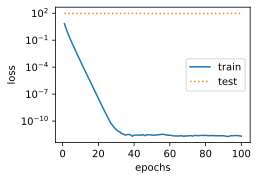

In [8]:
fit_and_plot(lambd=0)

### 3.12.3.5 使用权重衰减

L2 norm of w: 0.034895509481430054


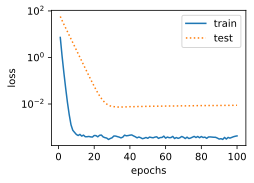

In [9]:
fit_and_plot(lambd=3)

## 3.12.4 简洁实现

In [10]:
help(torch.optim.SGD)

Help on class SGD in module torch.optim.sgd:

class SGD(torch.optim.optimizer.Optimizer)
 |  SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
 |  
 |  Implements stochastic gradient descent (optionally with momentum).
 |  
 |  Nesterov momentum is based on the formula from
 |  `On the importance of initialization and momentum in deep learning`__.
 |  
 |  Args:
 |      params (iterable): iterable of parameters to optimize or dicts defining
 |          parameter groups
 |      lr (float): learning rate
 |      momentum (float, optional): momentum factor (default: 0)
 |      weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
 |      dampening (float, optional): dampening for momentum (default: 0)
 |      nesterov (bool, optional): enables Nesterov momentum (default: False)
 |  
 |  Example:
 |      >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
 |      >>> optimizer.zero_grad()
 |      >>> loss_fn

In [11]:
help(torch.nn.MSELoss)

Help on class MSELoss in module torch.nn.modules.loss:

class MSELoss(_Loss)
 |  MSELoss(size_average=None, reduce=None, reduction='mean')
 |  
 |  Creates a criterion that measures the mean squared error (squared L2 norm) between
 |  each element in the input :math:`x` and target :math:`y`.
 |  
 |  The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:
 |  
 |  .. math::
 |      \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
 |      l_n = \left( x_n - y_n \right)^2,
 |  
 |  where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
 |  (default ``'mean'``), then:
 |  
 |  .. math::
 |      \ell(x, y) =
 |      \begin{cases}
 |          \operatorname{mean}(L), &  \text{if reduction} = \text{'mean';}\\
 |          \operatorname{sum}(L),  &  \text{if reduction} = \text{'sum'.}
 |      \end{cases}
 |  
 |  :math:`x` and :math:`y` are tensors of arbitrary shapes with a total
 |  of :math:`n` elements each.
 |  
 |  The sum operation still o

In [12]:
loss = torch.nn.MSELoss()
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y)
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 14.272814750671387


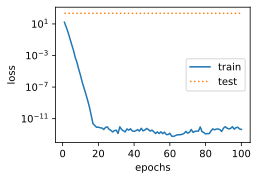

In [13]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.05102640017867088


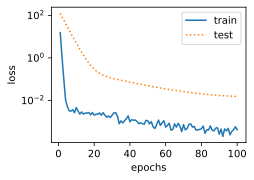

In [14]:
fit_and_plot_pytorch(3)